In [13]:
# ''' S.M.Ali Mousavi
# last saved at 2020-05-19 20:19:04 '''

# Legend:
#     HC : Helper Class
#     HF : Helper Function

In [14]:
# General imports
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random
import lightgbm as lgb

# custom imports
from multiprocessing import Pool        # Multiprocess Runs

warnings.filterwarnings('ignore')

In [15]:
import import_ipynb
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error as MAE 

# HF: Seeding

In [16]:
########################### Helpers
#################################################################################
## Seeder
# :seed to make all processes deterministic     # type: int
def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)

    
## Multiprocess Runs
def df_parallelize_run(func, t_split):
    num_cores = np.min([N_CORES,len(t_split)])
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, t_split), axis=1)
    pool.close()
    pool.join()
    return df

# LGBM Model Hyper Parameters setting

In [17]:
########################### Model params
#################################################################################
### https://lightgbm.readthedocs.io/en/latest/Parameters.html ###
import lightgbm as lgb
lgb_params = {
                    'boosting_type': 'gbdt',
                    'objective': 'tweedie',
                    'tweedie_variance_power': 1.1,
                    'metric': 'rmse',
                    'subsample': 0.5,
                    'subsample_freq': 1,
                    'learning_rate': 0.03,
                    'num_leaves': 2**11-1,
                    'min_data_in_leaf': 2**12-1,
                    'feature_fraction': 0.5,
                    'max_bin': 100,
                    'n_estimators': 1400,
                    'boost_from_average': False,
                    'verbose': -1,
                } 

# Let's look closer on params

## 'boosting_type': 'gbdt'
# we have 'goss' option for faster training
# but it normally leads to underfit.
# Also there is good 'dart' mode
# but it takes forever to train
# and model performance depends 
# a lot on random factor 
# https://www.kaggle.com/c/home-credit-default-risk/discussion/60921

## 'objective': 'tweedie'
# Tweedie Gradient Boosting for Extremely
# Unbalanced Zero-inflated Data
# https://arxiv.org/pdf/1811.10192.pdf
# and many more articles about tweediie
#
# Strange (for me) but Tweedie is close in results
# to my own ugly loss.
# My advice here - make OWN LOSS function
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/140564
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/143070
# I think many of you already using it (after poisson kernel appeared) 
# (kagglers are very good with "params" testing and tuning).
# Try to figure out why Tweedie works.
# probably it will show you new features options
# or data transformation (Target transformation?).

## 'tweedie_variance_power': 1.1
# default = 1.5
# set this closer to 2 to shift towards a Gamma distribution
# set this closer to 1 to shift towards a Poisson distribution
# my CV shows 1.1 is optimal 
# but you can make your own choice

## 'metric': 'rmse'
# Doesn't mean anything to us
# as competition metric is different
# and we don't use early stoppings here.
# So rmse serves just for general 
# model performance overview.
# Also we use "fake" validation set
# (as it makes part of the training set)
# so even general rmse score doesn't mean anything))
# https://www.kaggle.com/c/m5-forecasting-accuracy/discussion/133834

## 'subsample': 0.5
# Serves to fight with overfit
# this will randomly select part of data without resampling
# Chosen by CV (my CV can be wrong!)
# Next kernel will be about CV

##'subsample_freq': 1
# frequency for bagging
# default value - seems ok

## 'learning_rate': 0.03
# Chosen by CV
# Smaller - longer training
# but there is an option to stop 
# in "local minimum"
# Bigger - faster training
# but there is a chance to
# not find "global minimum" minimum

## 'num_leaves': 2**11-1
## 'min_data_in_leaf': 2**12-1
# Force model to use more features
# We need it to reduce "recursive"
# error impact.
# Also it leads to overfit
# that's why we use small 
# 'max_bin': 100

## l1, l2 regularizations
# https://towardsdatascience.com/l1-and-l2-regularization-methods-ce25e7fc831c
# Good tiny explanation
# l2 can work with bigger num_leaves
# but my CV doesn't show boost
                    
## 'n_estimators': 1400
# CV shows that there should be
# different values for each state/store.
# Current value was chosen 
# for general purpose.
# As we don't use any early stopings
# careful to not overfit Public LB.

##'feature_fraction': 0.5
# LightGBM will randomly select 
# part of features on each iteration (tree).
# We have maaaany features
# and many of them are "duplicates"
# and many just "noise"
# good values here - 0.5-0.7 (by CV)

## 'boost_from_average': False
# There is some "problem"
# to code boost_from_average for 
# custom loss
# 'True' makes training faster
# BUT carefull use it
# https://github.com/microsoft/LightGBM/issues/1514
# not our case but good to know cons

# Setting global variables

In [21]:
########################### Vars
#################################################################################
VER = 1                          # Our model version
SEED = 42                        # We want all things
seed_everything(SEED)            # to be as deterministic 
lgb_params['seed'] = SEED        # as possible
N_CORES = psutil.cpu_count()     # Available CPU cores


#LIMITS and const
TARGET      = 'sales'            # Our target
START_TRAIN = 0                  # We can skip some rows (Nans/faster training)
END_TRAIN   = 1913               # End day of our train set
P_HORIZON   = 12                 # Prediction horizon #vtM5crew 12days #DarkMagic=28days
USE_AUX     = True               # Use or not pretrained models

#FEATURES to remove
## These features lead to overfit
## or values not present in test set
remove_features = ['id','state_id','store_id',
                   'date','wm_yr_wk','d',TARGET]
mean_features   = ['enc_cat_id_mean','enc_cat_id_std',
                   'enc_dept_id_mean','enc_dept_id_std',
                   'enc_item_id_mean','enc_item_id_std'] 

#PATHS for Features
Absolute = '' # 'G://My Drive/Machine Learning/Kaggle Projects/M5/m5vtmechcrew/'
Cache    = 'Cache/'
ORIGINAL = 'Data/'
SALES    = 'sales_train_validation.csv'
BASE     = Absolute+'m5-simple-fe/grid_part_1.pkl'
PRICE    = Absolute+'m5-simple-fe/grid_part_2.pkl'
CALENDAR = Absolute+'m5-simple-fe/grid_part_3.pkl'
LAGS     = 'm5-lags-features/lags_df_28.pkl'
MEAN_ENC = 'm5-custom-features/mean_encoding_df.pkl'


# AUX(pretrained) Models paths
AUX_MODELS = '../input/m5-aux-models/'


#STORES ids
STORES_IDS = pd.read_csv(Absolute+ORIGINAL+SALES)['store_id']
STORES_IDS = list(STORES_IDS.unique())


#SPLITS for lags creation
SHIFT_DAY  = 28
N_LAGS     = 15
LAGS_SPLIT = [col for col in range(SHIFT_DAY,SHIFT_DAY+N_LAGS)]
ROLS_SPLIT = []
for i in [1,7,14]:
    for j in [7,14,30,60]:
        ROLS_SPLIT.append([i,j])

# HC: Level Creator

In [19]:
class LevelsCreator:
    def __init__(self):
        pass
    
    def level_11(self,sales_data):
        df = sales_data.groupby(['item_id', 'state_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    def level_10(self,sales_data):
        df= sales_data.groupby(['item_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    def level_9(self,sales_data):
        df= sales_data.groupby(['store_id', 'dept_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    def level_8(self,sales_data):
        df= sales_data.groupby(['store_id', 'cat_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    def level_7(self,sales_data):
        df= sales_data.groupby(['state_id', 'dept_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    def level_6(self,sales_data):
        df= sales_data.groupby(['state_id', 'cat_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    def level_5(self,sales_data):
        df= sales_data.groupby(['dept_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    def level_4(self,sales_data):
        df= sales_data.groupby(['cat_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    def level_3(self,sales_data):
        df= sales_data.groupby(['store_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    def level_2(self,sales_data):
        df= sales_data.groupby(['state_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    def level_1(self,sales_data):
        df= (pd.DataFrame(self.level_2(sales_data).sum())).transpose()
        return df        

# HF: Loading data

In [22]:
# import LevelsCreater as lc

# SALES='sales_train_validation.csv'
sale=pd.read_csv(Absolute+ORIGINAL+SALES); sale.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [23]:
# levels = LevelsCreator()
# level3 = levels.level_3(sale); level3.head()

In [24]:
# t = level3.loc[['CA_1']].T.rename_axis('days', axis=1); tt=t.shift(2); t.head()

# HF: series_to_supervised

In [ ]:
series_to_supervised(LevelsCreator().level_3(sale), n_in=3)

In [57]:
LevelsCreator().level_3(sale)

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
store_id,,,,,,,,,,,,,,,,,,,,,
CA_1,4337,4155,2816,3051,2630,3276,3450,5437,4340,3157,...,3982,5437,5954,4345,3793,3722,3709,4387,5577,6113
CA_2,3494,3046,2121,2324,1942,2288,2629,3729,2957,2218,...,4440,5352,5760,3830,3631,3691,3303,4457,5884,6082
CA_3,4739,4827,3785,4232,3817,4369,4703,5456,5581,4912,...,5337,6936,8271,6068,5683,5235,5018,5623,7419,7721
CA_4,1625,1777,1386,1440,1536,1389,1469,1988,1818,1535,...,2496,2839,3047,2809,2677,2500,2458,2628,2954,3271
TX_1,2556,2687,1822,2258,1694,2734,1691,2820,2887,2174,...,3084,3724,4192,3410,3257,2901,2776,3022,3700,4033
TX_2,3852,3937,2731,2954,2492,3439,2588,3772,3657,2932,...,3897,4475,4998,3311,3727,3384,3446,3902,4483,4292
TX_3,3030,3006,2225,2169,1726,2833,1947,2848,2832,2213,...,3819,4261,4519,3147,3938,3315,3380,3691,4083,3957
WI_1,2704,2194,1562,1251,2,2049,2815,3248,1674,1355,...,3862,4862,4812,3236,3069,3242,3324,3991,4772,4874
WI_2,2256,1922,2018,2522,1175,2244,2232,2643,2140,1836,...,6259,5579,5566,4347,4464,4194,4393,4988,5404,5127


In [56]:
series_to_supervised_l3(LevelsCreator().level_3(sale), n_in=30)

days,CA_1_t-30,CA_1_t-29,CA_1_t-28,CA_1_t-27,CA_1_t-26,CA_1_t-25,CA_1_t-24,CA_1_t-23,CA_1_t-22,CA_1_t-21,...,CA_1_t-10,CA_1_t-9,CA_1_t-8,CA_1_t-7,CA_1_t-6,CA_1_t-5,CA_1_t-4,CA_1_t-3,CA_1_t-2,CA_1_t-1
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4337.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4337.0,4155.0
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4337.0,4155.0,2816.0
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4337.0,4155.0,2816.0,3051.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,4242.0,3776.0,3770.0,3970.0,4904.0,6139.0,4669.0,3905.0,3788.0,3339.0,...,5969.0,4484.0,3579.0,3478.0,3637.0,3982.0,5437.0,5954.0,4345.0,3793.0
1909,3776.0,3770.0,3970.0,4904.0,6139.0,4669.0,3905.0,3788.0,3339.0,4076.0,...,4484.0,3579.0,3478.0,3637.0,3982.0,5437.0,5954.0,4345.0,3793.0,3722.0
1910,3770.0,3970.0,4904.0,6139.0,4669.0,3905.0,3788.0,3339.0,4076.0,4983.0,...,3579.0,3478.0,3637.0,3982.0,5437.0,5954.0,4345.0,3793.0,3722.0,3709.0
1911,3970.0,4904.0,6139.0,4669.0,3905.0,3788.0,3339.0,4076.0,4983.0,5877.0,...,3478.0,3637.0,3982.0,5437.0,5954.0,4345.0,3793.0,3722.0,3709.0,4387.0


In [26]:
def series_to_supervised_l3(data, store='CA_1', n_in=1, n_out=1, dropnan=False):

    n_vars = 1 if type(data) is list else data.shape[1]
    data_shifted=pd.DataFrame()
    names=list()
    # Selecting a store of interest, 
    # Transposing the days from being column to being the index
    data=data.loc[[store]].T
    
    # looping over the lag window(n_in) and making a new column
    for i in range(n_in, 0, -1):
        df=pd.DataFrame() #is this step necessary ?
        col_shifted=data.shift(i)
        col_shifted.columns=[f'{store}_t-{i}']
        data_shifted = pd.concat([data_shifted,col_shifted], axis=1, sort=False)

#     data_shifted.columns=col_names
    
#     for i in range(0, n_out):
#         df=pd.DataFrame()
#         names=list()
#         df=data.shift(-i)
#         if i == 0:
#             names += [('%s(t)' % (data.columns[j])) for j in range(n_vars)]
#         else:
#             names += [('%s(t+%d)' % (data.columns[j], i)) for j in range(n_vars)]
            
#         df.columns=names
#         cols=pd.concat([cols,df],axis=1,sort=False)
    
    # dropping the Nans if dropnan=True
    
    if dropnan:
        data_shifted.dropna(inplace=True)
        
  
    #reseting index from d_1...d_1913 to o...1912
    data_shifted.reset_index(drop=True, inplace=True)   
    # Renaming the index column from store_id to days
    data_shifted.rename_axis('days', axis=1, inplace=True) 
    
    return data_shifted

# HF: Train_test split  & LGB train_test DataSet builder

In [44]:
def train_validate_splitter_l3(data, store='CA_1', n_in=2, dropnan=False):
    # making supervised data
    Suervised_data = series_to_supervised_l3(data, store='CA_1',n_in=n_in, n_out=1, dropnan=dropnan)
    Target_data = data.loc[[store]].T.reset_index(drop=True)

    # Train (All data less than 1913)
    # "Validation" (Last 12 days - not real validation set)
    X_train = Suervised_data.iloc[:END_TRAIN-P_HORIZON]
    X_validate = Suervised_data.iloc[END_TRAIN-P_HORIZON:]
    y_train = Target_data.iloc[:END_TRAIN-P_HORIZON]
    y_validat = Target_data.iloc[END_TRAIN-P_HORIZON:]
    
    return X_train, X_validate, y_train, y_validat

# LGB library needs inputs in specific format of train_test dataset
# dataset includes in it X or features and y or label
def lgb_train_validate_set_builder(X_train, X_validate, y_train, y_validat):
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_validate, label=y_validat)
    return train_data, valid_data

# Training Predict Plot `MAE`

In [40]:
# X_train, X_validate, y_train, y_validat=\
# train_validate_splitter_l3(level3, store='CA_1', n_in=60)

In [41]:
# X_train

In [42]:
from sklearn.metrics import mean_absolute_error as MAE

In [45]:
levels = LevelsCreator()
level3 = levels.level_3(sale); level3.head()
error =[]
store = 'CA_1'

for lag in range(1,60):
    print(lag)
    X_train, X_validate, y_train, y_validat= \
    train_validate_splitter_l3(level3, store=store, n_in=lag, dropnan=True)
    
    train_data, valid_data = lgb_train_validate_set_builder(
                                 X_train, X_validate, y_train, y_validat
                                  )
    
    # Launch seeder again to make lgb training 100% deterministic
    # with each "code line" np.random "evolves" 
    # so we need (may want) to "reset" it
    seed_everything(SEED)
    estimator = lgb.train(lgb_params,
                          train_data,
                          valid_sets = [valid_data],
                          verbose_eval = 1
                          )
    
    # Save model - it's not real '.bin' but a pickle file
    # estimator = lgb.Booster(model_file='model.txt')
    # can only predict with the best iteration (or the saving iteration)
    # pickle.dump gives us more flexibility
    # like estimator.predict(TEST, num_iteration=100)
    # num_iteration - number of iteration want to predict with, 
    # NULL or <= 0 means use best iteration
    
    model_name = 'lgb_model_'+store+'_v'+str(VER)+'.bin' #just saves last trained model
    # pickling the trained models
    if not os.path.exists(Absolute+Cache):
        os.mkdir(Absolute+Cache)
    pickle.dump(estimator, open(Absolute+Cache+model_name, 'wb'))
    
    # In-sample prediction
    y_predict = estimator.predict(X_train)
    print(MAE(y_train, y_predict))
    error.append(MAE(y_train, y_predict))

1


LightGBMError: Length of label is not same with #data

In [301]:
print(f'error min {min(error)}\n  and max {max(error)}')

error min 783.7135077443393
  and max 783.7135077443393


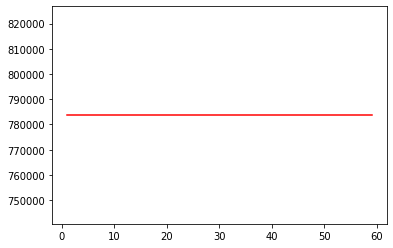

In [292]:
plt.plot(range(1,60),np.array(error)*1000, 'r-')